Inspiration
https://www.opensourcefootball.com/posts/2021-05-31-computer-vision-in-r-using-torch/

In [1]:
#from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from keras.preprocessing import image   # for preprocessing the images
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from glob import glob
from tqdm import tqdm
import math
from keras.models import Sequential, load_model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
import pydot
from tensorflow.keras.optimizers import SGD

#### Training

In [2]:
### load in charted data of actions
train_df = pd.read_csv("train_labels.csv")

### filter for offensive plays
play_list = ['pass','rush']

train_df = train_df[train_df['play_type'].isin(play_list)]




print(f"Total videos for training: {len(train_df)}")
#print(f"Total videos for testing: {len(test_df)}")

#train_df.drop(['Unnamed: 9'])

train_df.sample(9)


Total videos for training: 129


,video_name,playId,play_type,down lineman,edge rusher,blitzing man,qb spy,coverage,cover type,offensive_personnel
33,401331242101906101.mp4,4.010000e+17,pass,3,1,0,0,cover 2,zone,12
128,401114196103999901.mp4,4.011140e+17,pass,4,2,0,0,cover 0,man,11
55,401331242102854701.mp4,4.013310e+17,pass,3,1,1,0,cover 1,man,11
3,401331242101867601.mp4,4.010000e+17,pass,4,0,0,1,cover 1,man,1
89,400763462103867201.mp4,4.007630e+17,pass,4,0,0,0,cover 2,zone,20
21,401135295101876401.mp4,4.010000e+17,pass,3,1,1,0,cover 1,zone,10
59,401331242102889801.mp4,4.013310e+17,pass,2,2,0,1,cover 1,man,11
75,400935229101925601.mp4,4.009350e+17,rush,3,2,0,0,cover 2,zone,11
12,401135295101858801.mp4,4.010000e+17,pass,3,1,0,1,cover 1,man,11


Target variables for charting data

In [3]:
labels = pd.unique(train_df.coverage)
labels

array(['cover 1', 'cover 2', 'cover 0', 'cover 3', 'cover 4'],
      dtype=object)

Reference to Coverages: 
https://www.viqtorysports.com/defensive-coverages-in-football-complete-guide/

Offensive Personnel: 
https://thepaintedlines.com/football-101-personnel-groupings/


In [4]:
label_count = len(labels)
label_count

5

In [5]:
videos = pd.unique(train_df.video_name)

In [6]:
#train_df['tag'] = train_df['coverage'] + "/" + train_df['video_name']


Convert video to frames to generate training set

In [7]:
for i in tqdm(range(train_df.shape[0])):
    count = 0
    videoFile = train_df['video_name'].iloc[i]
    coverage  = train_df['coverage'].iloc[i]
    cap = cv2.VideoCapture('videos/train/'+ videoFile.split(' ')[0].split('/')[0])   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):   #### get every 5th frame to minimize processing
            # storing the frames in a new folder named train_1
            filename ='train_1/' + coverage + "_" + videoFile.split(' ')[0].split('/')[0] +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

  2%|▋                                          | 2/129 [00:00<00:42,  2.97it/s]OpenCV: Couldn't read video stream from file "videos/train/401331242101859501.mp4"
[ERROR:0@2.338] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


  5%|██▎                                        | 7/129 [00:02<00:41,  2.92it/s]OpenCV: Couldn't read video stream from file "videos/train/401331242101889301.mp4"
[ERROR:0@3.862] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_numbe

Tie images to target variables and output to csv

In [8]:
# getting the names of all the images
images = glob("train_1/*.jpg")
train_image = []
train_class = []
for i in tqdm(range(len(images))):
    # creating the image name
    train_image.append(images[i].split('/')[1])
    # creating the class of image
    train_class.append(images[i].split('/')[1].split('_')[0])
    
# storing the images and their class in a dataframe
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

# converting the dataframe into csv file 
train_data.to_csv('train_new.csv',header=True, index=False)

100%|███████████████████████████████████| 1554/1554 [00:00<00:00, 539743.99it/s]


In [9]:
train = pd.read_csv('train_new.csv')
train.head()

,image,class
0,cover 3_400935229101866201.mp4_frame5.jpg,cover 3
1,cover 2_401331242101959801.mp4_frame3.jpg,cover 2
2,cover 1_401331242101917301.mp4_frame15.jpg,cover 1
3,cover 2_401331242101856501.mp4_frame7.jpg,cover 2
4,cover 0_401331242102917301.mp4_frame9.jpg,cover 0


<AxesSubplot:>

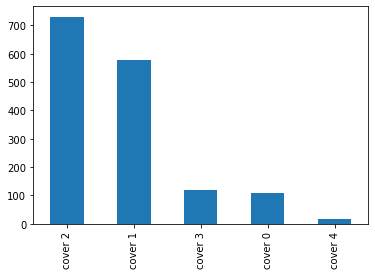

In [10]:
train['class'].value_counts().plot(kind='bar')

Fair amount of target variable imbalance as expected in the college game

In [11]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('train_1/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
X = np.array(train_image)

# shape of the array
X.shape

100%|██████████████████████████████████████| 1554/1554 [00:08<00:00, 181.74it/s]


(1554, 224, 224, 3)

In [12]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2,
                                                   stratify = y)

In [13]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

- Don't have a very large dataset so we will need some assistance from a pre-trained model;
- As dataset grows, swap out CNN to custom architecture.
- Add custom architecture on top of pre-trained model (Include_top=False) helps to train to our custom architecture

In [14]:
#base_model = VGG16(weights='imagenet', include_top=False)

Extract features from base model to train custom architecture

In [15]:
#X_train = base_model.predict(X_train)
X_train.shape

(1243, 224, 224, 3)

In [16]:
#X_test = base_model.predict(X_test)
X_test.shape

(311, 224, 224, 3)

In [17]:
#X_train = X_train.reshape(X_train.shape[0],7*7*512)
#X_test  = X_test.reshape(X_test.shape[0],7*7*512)

Normalize pixel values

In [18]:
max = X_train.max()
X_train = X_train/max
X_test  = X_test/max

In [19]:
X_train.shape

(1243, 224, 224, 3)

create architecture

In [20]:
### VG661 architecture
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


## now add bottom 
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1024,activation='relu'))
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(label_count,activation = 'softmax'))

2022-10-04 15:07:12.852927: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
### additional layer on top of image net structure

#model = Sequential()
#model.add(Dense(1024,activation = 'relu',input_shape=(25088,)))
#model.add(Dense(1024,activation = 'relu',input_shape=(224,224,3)))
#model.add(Dense(1024,activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(512,activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(256,activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(128,activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.4))
#model.add(Dense(label_count,activation = 'softmax')) ### neurons of final equal to number of classes

In [22]:
checkpoint = ModelCheckpoint('weight.hdf5', 
                           save_best_only=True, 
                           monitor='val_loss', 
                           mode='min')


#early = EarlyStopping(monitor='val_acc',
#                      min_delta=0,
#                     patience=15,
#                     verbose=1,
#                     mode='auto')


In [23]:
opt = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              #optimizer='Adam',
              optimizer = opt,
              metrics=['accuracy'])

In [24]:
model.fit(X_train, 
          y_train, 
          epochs=25, 
          validation_data=(X_test, y_test), 
          callbacks=[checkpoint], #,early
          batch_size=128)


Epoch 1/25
10/10 [==============================] - 1225s 122s/step - loss: 1.5858 - accuracy: 0.4521 - val_loss: 1.5523 - val_accuracy: 0.4695
Epoch 2/25
10/10 [==============================] - 3265s 349s/step - loss: 1.5290 - accuracy: 0.4714 - val_loss: 1.4967 - val_accuracy: 0.4695
Epoch 3/25
10/10 [==============================] - 1351s 137s/step - loss: 1.4821 - accuracy: 0.4714 - val_loss: 1.4493 - val_accuracy: 0.4695
Epoch 4/25
10/10 [==============================] - 3075s 309s/step - loss: 1.4369 - accuracy: 0.4722 - val_loss: 1.4069 - val_accuracy: 0.4695
Epoch 5/25
10/10 [==============================] - 1353s 137s/step - loss: 1.4014 - accuracy: 0.4682 - val_loss: 1.3707 - val_accuracy: 0.4695
Epoch 6/25
10/10 [==============================] - 2059s 215s/step - loss: 1.3667 - accuracy: 0.4739 - val_loss: 1.3390 - val_accuracy: 0.4695
Epoch 7/25
10/10 [==============================] - 1975s 198s/step - loss: 1.3369 - accuracy: 0.4682 - val_loss: 1.3118 - val_accuracy:

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

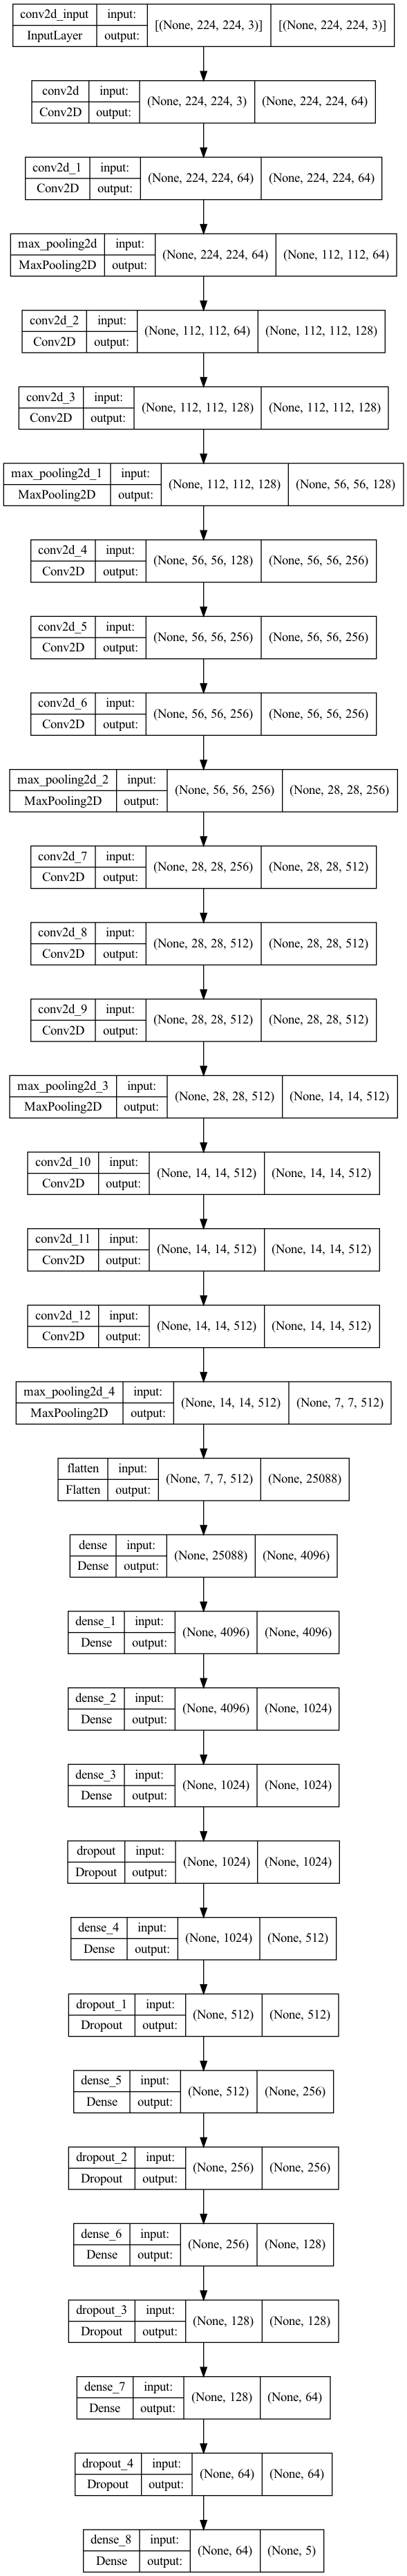

In [26]:
plot_model(model, 
           to_file='coverage_model_plot.png', 
           show_shapes=True, 
           show_layer_names=True)




In [27]:
#defining the model architecture
#model = Sequential()
#model.add(Dense(1024, activation='relu', input_shape=(25088,)))
#model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.4))
#model.add(Dense(label_count, activation='softmax'))

In [28]:
### weights not found
#model.load_weights("weights.hdf5")

In [29]:
#model.compile(loss='categorical_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

In [30]:
model.save('coverage_model.h5')

### evaluate test

In [31]:
model = keras.models.load_model('coverage_model.h5')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [33]:
test_df = pd.read_csv("test_labels.csv")

In [34]:
test = pd.DataFrame()

In [35]:
test['video_name'] = test_df['video_name'] 

test_videos = test['video_name']

In [36]:
train = pd.read_csv('train_new.csv')
y = train['class']
y = pd.get_dummies(y)

### Work in Progress to reshape

In [39]:
predict = []
actual = []
predict_probs = []

# for loop to extract frames from each test video
for i in tqdm(range(test_videos.shape[0])):
    count = 0
    videoFile = test_videos[i]
    coverage  = test_df['coverage'].iloc[i]
    cap = cv2.VideoCapture('videos/test/'+videoFile.split(' ')[0].split('/')[0])   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1
    # removing all other files from the temp folder; Only keep first frame in temp file for pre-snap prediction
    files = glob('temp/*')
    for f in files:
        if not f.endswith('_frame0.jpg'):
            os.remove(f)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames of this particular video in temp folder
            filename ='temp/' + str(videoFile.split(' ')[0].split('/')[0]) + '_' + str(coverage) + "_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    
    # reading all the frames from temp folder
    images = glob("temp/*.jpg")
    
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        prediction_images.append(img)
        
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    #prediction_images = prediction_images.reshape(prediction_images.shape[0], 25888)
    #prediction_images = base_model.predict(prediction_images)
    prediction_images = model.predict(prediction_images)
    # converting features in one dimensional array
    #prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction_probs = model.predict(prediction_images)
    #prediction = model.predict(prediction_images)
    prediction = np.argmax(prediction_probs,axis=1)
    prediction = np.where(prediction == 0,labels[0],
                 np.where(prediction == 1,labels[1],
                 np.where(prediction == 2,labels[2],
                 np.where(prediction == 3,labels[3],
                 np.where(prediction == 4,labels[4],
                         np.nan))
                         )))
    #print(prediction)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(prediction[0])
    predict_probs.append(prediction_probs[0])
    # appending the actual tag of the video
    actual.append(images[i].split('/')[1].split('_')[1])
    

  0%|                                                    | 0/24 [00:15<?, ?it/s]


ValueError: in user code:

    File "/Users/qmaclean/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/Users/qmaclean/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/qmaclean/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/qmaclean/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/Users/qmaclean/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/qmaclean/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 5)


In [ ]:
predict

In [ ]:
actual

In [ ]:
accuracy_score(predict,actual)*1

https://www.analyticsvidhya.com/blog/2019/09/step-by-step-deep-learning-tutorial-video-classification-python/

### Plot sample

In [ ]:
i = 9
img_grayscale = cv2.imread(images[i])

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
color = (255,255,255)

cv2.rectangle(img_grayscale,(0,0),(150,73),(245,117,16),-1)
cv2.putText(img_grayscale, 'Coverage Prediction:', (15, 15),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255),1)
cv2.putText(img_grayscale, '{}'.format(predict[i]), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
cv2.putText(img_grayscale, 'Coverage Actual:', (15, 45),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255),1)
cv2.putText(img_grayscale, '{}'.format(actual[i]), (10, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)

cv2.imshow('image',img_grayscale)
#cv2.putText(img_gray)000
cv2.waitKey(0)
cv2.destroyAllWindows()



# To-do
- Add weights to output?
- Check class imbalance
- Input shape when loading model 

Utilize for prediction

https://keras.io/examples/vision/video_classification/